In [66]:
import pathlib
import numpy as np

labels = {
    'csvgd': 'CSVTO (Ours)',
    'ipopt': 'IPOPT',
    'ipopt_to_convergence': 'IPOPT (To Convergence)',
    'mppi_100': 'MPPI $\lambda$ = 100',
    'mppi_1000': 'MPPI $\lambda$ = 1000',
    'svgd_100': 'SVMPC $\lambda$ = 100',
    'svgd_1000': 'SVMPC $\lambda$ = 1000',
    'svgd_grad_100': 'SVMPC-grad $\lambda$ = 100',
    'svgd_grad_1000': 'SVMPC-grad $\lambda$ = 1000'
}
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rc('axes', labelsize=14) 

ccai_path = pathlib.Path().resolve().parents[0]

def get_quadrotor_results(experiments_fpath):
    controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
    print(controllers)
    num_trials = 20

    min_distance_to_goals = {}
    for controller in controllers:
        min_distance_to_goals[str(controller)] = []

    average_constraint_violation = {}
    for controller in controllers:
        average_constraint_violation[str(controller)] = []

    worst_constraint_violation = {}
    for controller in controllers:
        worst_constraint_violation[str(controller)] = []

    #controller_list = ['csvgd', 'ipopt', 'mppi_100', 'mppi_1000', 'svgd_100', 'svgd_1000', 'svgd_grad_100', 'svgd']
    controllers.sort()
    for controller in controllers:
        for i in range(1, num_trials + 1):
            fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
            data = np.load(fpath)
            x = data['x']
            violation = np.abs(data['constr'][:, 0])

            # distance to goal
            min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))
            #min_d = np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))
            min_distance_to_goals[str(controller)].append(min_d)
            average_constraint_violation[str(controller)].append(violation)
            worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))
        average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)

    return min_distance_to_goals, average_constraint_violation, worst_constraint_violation, controllers

[PosixPath('ipopt'), PosixPath('csvgd'), PosixPath('mppi_1000'), PosixPath('svgd_100'), PosixPath('mppi_100'), PosixPath('svgd_grad_100'), PosixPath('svgd_1000'), PosixPath('svgd_grad_1000')]
[PosixPath('ipopt'), PosixPath('csvgd'), PosixPath('mppi_1000'), PosixPath('svgd_100'), PosixPath('mppi_100'), PosixPath('svgd_grad_100'), PosixPath('svgd_1000'), PosixPath('svgd_grad_1000')]
[PosixPath('ipopt'), PosixPath('csvgd'), PosixPath('mppi_1000'), PosixPath('svgd_100'), PosixPath('mppi_100'), PosixPath('svgd_grad_100'), PosixPath('svgd_1000'), PosixPath('svgd_grad_1000')]
dict_keys(['ipopt', 'csvgd', 'mppi_1000', 'svgd_100', 'mppi_100', 'svgd_grad_100', 'svgd_1000', 'svgd_grad_1000'])


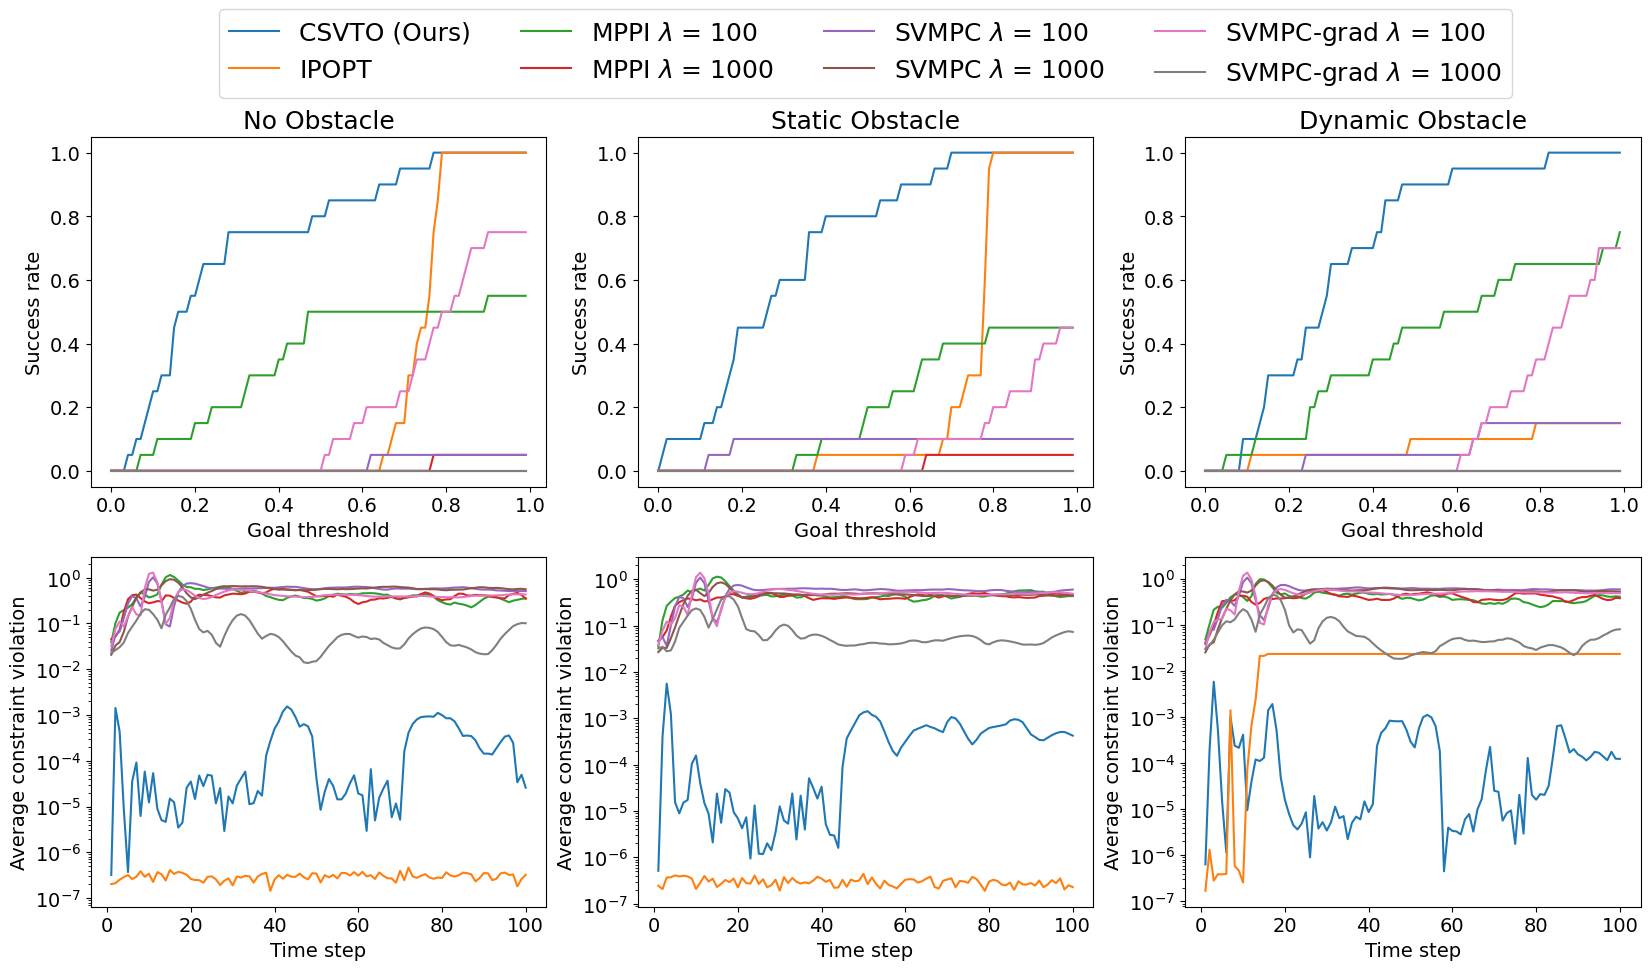

In [67]:
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_dynamic_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_dynamic, av_v_dynamic, _, controllers = get_quadrotor_results(experiments_fpath)
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_static_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_static, av_v_static, _, _ = get_quadrotor_results(experiments_fpath)
experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/quadrotor_noobs_temp_05_N8_wide_start2_heuristic2_penalty_100')
min_d_none, av_v_none, _, _ = get_quadrotor_results(experiments_fpath)
print(min_d_dynamic.keys())
min_d = {
    'none': min_d_none,
    'static': min_d_static,
    'dynamic': min_d_dynamic,
}
av_v = {
    'none': av_v_none,
    'static': av_v_static,
    'dynamic': av_v_dynamic,
}
goal_thresholds = np.arange(0, 1, 0.01)

success_rates = {}
for exp_type in min_d.keys():
    success_rates[exp_type] = {}
    for controller in controllers:
        success_rates[exp_type][str(controller)] = np.zeros(len(goal_thresholds))
        min_d[exp_type][str(controller)] = np.array(min_d[exp_type][str(controller)])
        av_v[exp_type][str(controller)] = np.array(av_v[exp_type][str(controller)])
        for i, threshold in enumerate(goal_thresholds):
            s = np.where(min_d[exp_type][str(controller)] < threshold, 1, 0).sum() / len(min_d[exp_type][str(controller)])
            success_rates[exp_type][str(controller)][i] = s

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

label_exp_type = {
    'dynamic': 'Dynamic Obstacle',
    'static': 'Static Obstacle',
    'none': 'No Obstacle'
}
for i, exp_type in enumerate(min_d.keys()):
    for j, controller in enumerate(controllers):
        axes[0, i].plot(
            goal_thresholds,
            success_rates[exp_type][str(controller)],
            label=fr'{labels[str(controller)]}'
        )
        axes[0, i].set_title(label_exp_type[exp_type], fontsize=18)
        axes[0, i].set_xlabel('Goal threshold')
        axes[0, i].set_ylabel('Success rate')
        axes[1, i].plot(
            np.arange(1, 101),
            av_v[exp_type][str(controller)],
            label=fr'{labels[str(controller)]}'
        )
        axes[1, i].set_xlabel('Time step')
        axes[1, i].set_ylabel('Average constraint violation')
        axes[1, i].set_yscale('log')

axes[0, 0].legend(loc='upper center', bbox_to_anchor=(1.7, 1.4),
ncol=4, fancybox=True, shadow=False, fontsize=18)
plt.show()


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]


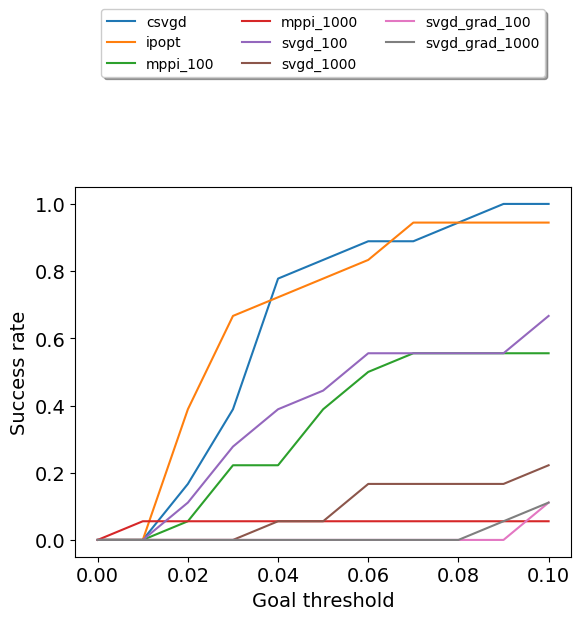

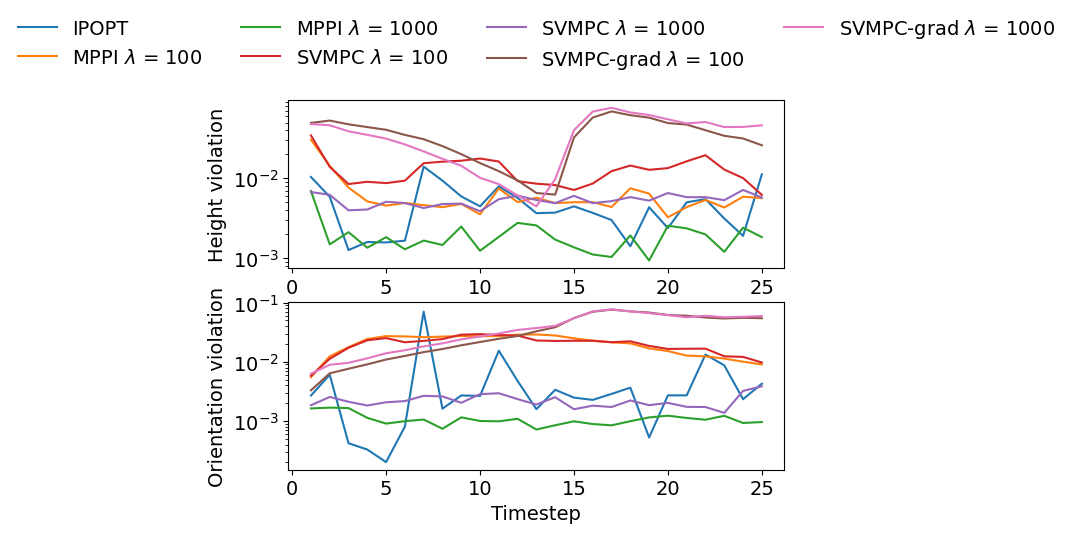

In [102]:
### victor table figs
import pathlib
import numpy as np
labels = {
    'csvgd_zero_hess2': 'CSVTO (Ours)',
    'ipopt': 'IPOPT',
    'mppi_100': 'MPPI $\lambda$ = 100',
    'mppi_1000': 'MPPI $\lambda$ = 1000',
    'svgd_100': 'SVMPC $\lambda$ = 100',
    'svgd_1000': 'SVMPC $\lambda$ = 1000',
    'svgd_grad_100': 'SVMPC-grad $\lambda$ = 100',
    'svgd_grad_1000': 'SVMPC-grad $\lambda$ = 1000'
}
ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/victor_table_jointspace_zero_hess_2023_12_15')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 18

min_distance_to_goals = {}
applied_force = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
        data = np.load(fpath)
        x = data['x']
        violation = np.abs(data['constr']).reshape(-1, 2)

        # z violation
        #violation[:, 0] = np.clip(violation[:, 0] - 3e-3, a_max=None, a_min=0)

        # distance to goal
        #min_d = np.min(np.linalg.norm((x[:, :2] - np.array([4.0, 4.0]).reshape(-1, 2)), axis=1))

        min_d = np.min(data['d2goal'])
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(violation)

        worst_constraint_violation[str(controller)].append(np.max(np.abs(violation)))

    average_constraint_violation[str(controller)] = np.mean(np.stack(average_constraint_violation[str(controller)], axis=0), axis=0)
goal_thresholds = np.arange(0, 0.101, 0.01)
print(goal_thresholds)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(np.logical_and(min_d < threshold, max_v < 1) , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s



import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)
axes = [axes]

for controller in controllers:
    axes[0].plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=str(controller)
    )
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=3, fancybox=True, shadow=True) 
axes[0].set_xlabel('Goal threshold')
axes[0].set_ylabel('Success rate')
plt.show()
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1)
for controller in controllers:

    if str(controller) not in labels.keys():
        continue
    
    axes[0].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 0],
        label=labels[str(controller)]
    )
    axes[1].plot(
        np.arange(1, 26),
        average_constraint_violation[str(controller)][1:, 1],
        label=labels[str(controller)]
    )
    #axes[1].set_ylim([-0.005, 0.005])
#
axes[0].set_yscale('log')
axes[1].set_yscale('log')

plt.xlabel('Timestep')
axes[0].set_ylabel('Height violation')
axes[1].set_ylabel('Orientation violation')

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.6),
          ncol=4, fancybox=False, shadow=False, frameon=False, fontsize=14)
plt.show()


csvgd
[0.   0.   0.7  0.95 1.   1.   1.   1.   1.   1.  ]
ipopt
[0.   0.   0.1  0.4  0.6  0.75 0.8  0.9  0.95 0.95]
mppi_100
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
mppi_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
svgd_100
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.05]
svgd_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
svgd_grad_100
[0.   0.   0.   0.   0.   0.   0.   0.1  0.35 0.4 ]
svgd_grad_1000
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


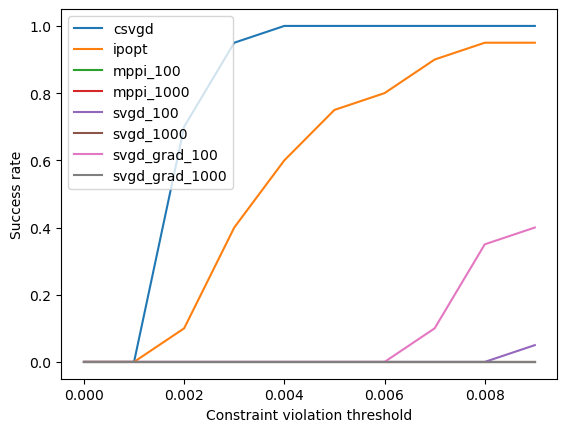

In [344]:
thresholds = np.arange(0.0, 0.01, 0.001)
controllers.sort()
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(thresholds)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    max_v = np.array(worst_constraint_violation[str(controller)])
    for i, threshold in enumerate(thresholds):
        s = np.where(np.logical_and(min_d < 0.1, max_v < threshold), 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s

import matplotlib.pyplot as plt
for controller in controllers:

    print(controller)
    print(success_rates[str(controller)])
    plt.plot(
        thresholds,
        success_rates[str(controller)],
        label=str(controller)
    )
plt.xlabel('Constraint violation threshold')
plt.ylabel('Success rate')
plt.legend()
plt.show()

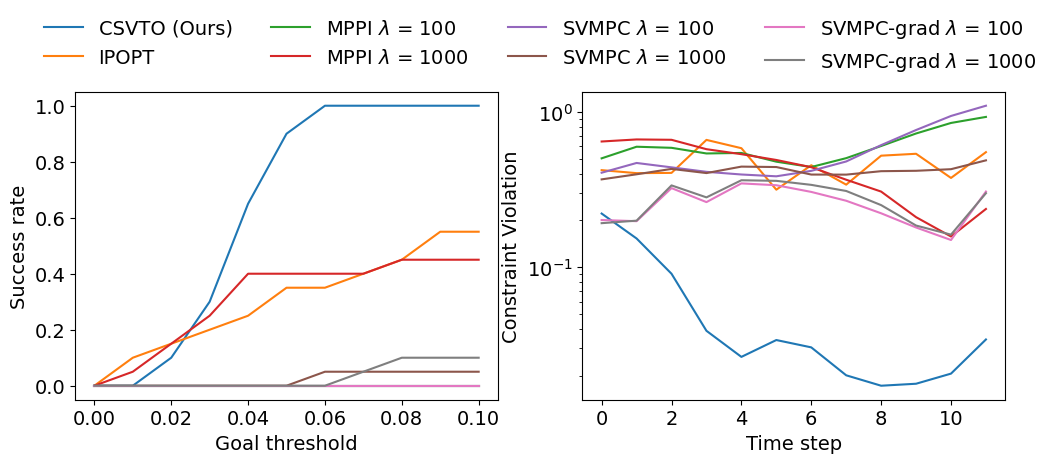

In [98]:
### victor table figs
import pathlib
import numpy as np
labels = {
    'csvgd_zero_hess2': 'CSVTO (Ours)',
    'ipopt': 'IPOPT',
    'mppi_100': 'MPPI $\lambda$ = 100',
    'mppi_1000': 'MPPI $\lambda$ = 1000',
    'svgd_100': 'SVMPC $\lambda$ = 100',
    'svgd_1000': 'SVMPC $\lambda$ = 1000',
    'svgd_grad_100': 'SVMPC-grad $\lambda$ = 100',
    'svgd_grad_1000': 'SVMPC-grad $\lambda$ = 1000'
}

ccai_path = pathlib.Path().resolve().parents[0]

experiments_fpath = pathlib.Path(f'{ccai_path}/data/experiments/victor_wrench_bfgs')

controllers = [p.relative_to(experiments_fpath) for p in experiments_fpath.iterdir()]
controllers.sort()
num_trials = 20

min_distance_to_goals = {}
applied_force = {}
for controller in controllers:
    min_distance_to_goals[str(controller)] = []

average_constraint_violation = {}
worst_constraint_violation = {}

for controller in controllers:
    average_constraint_violation[str(controller)] = []

for controller in controllers:
    worst_constraint_violation[str(controller)] = []

for controller in controllers:
    applied_force[str(controller)] = []

for controller in controllers:
    for i in range(1, num_trials + 1):
        fpath = f'{experiments_fpath}/{controller}/trial_{i}/trajectory.npz'
        data = dict(np.load(fpath))
        x = data['x']
        violation = data['g'][4:-1].reshape(-1, 4)
        violation = np.max(np.abs(violation), axis=1)
        min_d = np.min(np.abs((x[-1, -1] + np.pi / 2.0)))
        min_distance_to_goals[str(controller)].append(min_d)
        average_constraint_violation[str(controller)].append(violation)
        #print(min_d, controller)

goal_thresholds = np.arange(0, 0.11, 0.01)
success_rates = {}
for controller in controllers:
    success_rates[str(controller)] = np.zeros_like(goal_thresholds)
    average_constraint_violation[str(controller)] = np.mean(average_constraint_violation[str(controller)], axis=0)

for controller in controllers:
    min_d = np.array(min_distance_to_goals[str(controller)])
    for i, threshold in enumerate(goal_thresholds):
        s = np.where(min_d < threshold , 1, 0).sum() / len(min_d)
        success_rates[str(controller)][i] = s
    #print(controller, success_rates[str(controller)][-1])


import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for controller in controllers:
    if str(controller) not in labels.keys():
        continue
    axes[0].plot(
        goal_thresholds,
        success_rates[str(controller)],
        label=labels[str(controller)]
    )
    t = np.arange(0, 12)
    axes[1].plot(
        t,
        average_constraint_violation[str(controller)],
        label=labels[str(controller)]
    )
axes[0].set_xlabel('Goal threshold')
axes[0].set_ylabel('Success rate')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Constraint Violation')
axes[1].set_yscale('log')
plt.gca().legend(loc='upper center', bbox_to_anchor=(-0.1, 1.3),
          ncol=4, fancybox=False, shadow=False, frameon=False, fontsize=14)
plt.savefig('/home/tpower/wrench_results.pdf')
plt.show()